<a href="https://colab.research.google.com/github/Vinicius-DataAnalyst/portfolio/blob/main/12_PROJ_FacialRecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade --no-deps torch torchvision facenet-pytorch --quiet
!pip install opencv-python

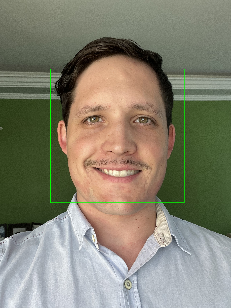

In [3]:
import cv2
from google.colab.patches import cv2_imshow

# Carrega um classificador pré-treinado para rostos
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Carrega uma imagem
uploaded_img_path = '/content/drive/MyDrive/01.FIAP_Graduação/2025/FASE06_trabalho/img_rosto.jpg'
img = cv2.imread(uploaded_img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detecta rostos
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Desenha retângulos nos rostos
for (x, y, w, h) in faces:
    # Increased thickness to 5 and changed color to green (0, 255, 0)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)

# Mostra o resultado - Redimensiona a imagem antes de mostrar
resized_img = cv2.resize(img, (int(img.shape[1] * 0.1), int(img.shape[0] * 0.1))) # Reduz para 10%
cv2_imshow(resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
import os
import numpy as np
from PIL import Image
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity

# Caminhos
train_dir = '/content/drive/MyDrive/01.FIAP_Graduação/2025/FASE06_trabalho/Atividade1-Reconhecimento Facial/Atividade1-Reconhecimento Facial/train'
test_dir = '/content/drive/MyDrive/01.FIAP_Graduação/2025/FASE06_trabalho/Atividade1-Reconhecimento Facial/Atividade1-Reconhecimento Facial/test'

# GPU se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando device:", device)

# Modelos
mtcnn = MTCNN(image_size=160, margin=0, keep_all=False, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def gerar_embedding(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except:
        print(f"Erro ao abrir {img_path}")
        return None
    face = mtcnn(img)
    if face is None:
        print(f"Nenhum rosto detectado em {img_path}")
        return None
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(face)
    return emb.cpu().numpy().flatten()

# Gera média dos embeddings de treino
print("🔹 Gerando embeddings médios de treino...")
embeddings_treino = {}
for pessoa in os.listdir(train_dir):
    pasta = os.path.join(train_dir, pessoa)
    if not os.path.isdir(pasta):
        continue
    embs = []
    for img_name in os.listdir(pasta):
        img_path = os.path.join(pasta, img_name)
        emb = gerar_embedding(img_path)
        if emb is not None:
            embs.append(emb)
    if embs:
        embeddings_treino[pessoa] = np.mean(embs, axis=0)
        print(f"{pessoa}: {len(embs)} imagens processadas")

# Lê as imagens na pasta Test
print("\n🔹 Testando imagens individuais...")
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    if not os.path.isfile(img_path):
        continue

    emb_teste = gerar_embedding(img_path)
    if emb_teste is None:
        continue

    # Calcula similaridade de cosseno com todos os embeddings médios
    similaridades = {
        nome: cosine_similarity([emb_teste], [emb_ref])[0][0]
        for nome, emb_ref in embeddings_treino.items()
    }

    reconhecido = max(similaridades, key=similaridades.get)
    confianca = similaridades[reconhecido]

    print(f"Arquivo: {img_name:20s} | Previsto: {reconhecido:12s} | Similaridade: {confianca:.3f}")


Usando device: cuda


  0%|          | 0.00/107M [00:00<?, ?B/s]

🔹 Gerando embeddings médios de treino...
cr7: 4 imagens processadas
kaka: 4 imagens processadas
messi: 4 imagens processadas
neymar: 4 imagens processadas
ronaldinho: 4 imagens processadas

🔹 Testando imagens individuais...
Arquivo: Cr75.jpeg            | Previsto: cr7          | Similaridade: 0.835
Arquivo: kaka5.jpeg           | Previsto: kaka         | Similaridade: 0.728
Arquivo: Messi5.jpeg          | Previsto: messi        | Similaridade: 0.804
Arquivo: Neymar5.jpeg         | Previsto: neymar       | Similaridade: 0.791
Arquivo: Ronaldinho5.jpeg     | Previsto: ronaldinho   | Similaridade: 0.799
